In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [5]:
!cp kaggle.json ~/.kaggle/

In [9]:

!chmod 600 ~/.kaggle/kaggle.json

Import The Dataset From Kaggle

In [6]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [01:45<00:00, 93.5MB/s]
100% 5.20G/5.20G [01:45<00:00, 52.8MB/s]


In [7]:
!ls

kaggle.json  sample_data  skin-cancer-mnist-ham10000.zip


Unzip The Dataset

In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

In [ ]:
import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical,normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from keras import regularizers
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [11]:
import os
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join( '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Load The Dataset

In [12]:
df = pd.read_csv(os.path.join('HAM10000_metadata.csv'))
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
296,HAM_0004566,ISIC_0029394,bkl,histo,55.0,female,lower extremity,HAM10000_images_part_2/ISIC_0029394.jpg,Benign keratosis-like lesions,2
6797,HAM_0006197,ISIC_0028332,nv,histo,40.0,male,back,HAM10000_images_part_1/ISIC_0028332.jpg,Melanocytic nevi,4
7125,HAM_0002494,ISIC_0033686,nv,histo,65.0,female,abdomen,HAM10000_images_part_2/ISIC_0033686.jpg,Melanocytic nevi,4
6283,HAM_0006562,ISIC_0031084,nv,follow_up,40.0,male,trunk,HAM10000_images_part_2/ISIC_0031084.jpg,Melanocytic nevi,4
5358,HAM_0005635,ISIC_0024878,nv,follow_up,80.0,male,trunk,HAM10000_images_part_1/ISIC_0024878.jpg,Melanocytic nevi,4
2148,HAM_0002906,ISIC_0027517,mel,histo,70.0,male,ear,HAM10000_images_part_1/ISIC_0027517.jpg,Melanoma,5
7672,HAM_0000676,ISIC_0033894,nv,histo,40.0,male,back,HAM10000_images_part_2/ISIC_0033894.jpg,Melanocytic nevi,4
7086,HAM_0005686,ISIC_0033112,nv,histo,25.0,male,back,HAM10000_images_part_2/ISIC_0033112.jpg,Melanocytic nevi,4
4127,HAM_0005890,ISIC_0027653,nv,follow_up,60.0,male,abdomen,HAM10000_images_part_1/ISIC_0027653.jpg,Melanocytic nevi,4
914,HAM_0003218,ISIC_0033305,bkl,consensus,75.0,male,back,HAM10000_images_part_2/ISIC_0033305.jpg,Benign keratosis-like lesions,2


Check The Missing Value

In [13]:
df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

Fill The Missing Values

In [14]:
df['age'].fillna((df['age'].median()), inplace=True)

In [15]:
from PIL import Image
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))
df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033084.jpg,Actinic keratoses,0,"[[[155, 137, 148], [154, 136, 147], [151, 134,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033550.jpg,Actinic keratoses,0,"[[[5, 6, 4], [6, 7, 4], [7, 8, 6], [7, 7, 5], ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,HAM10000_images_part_2/ISIC_0033536.jpg,Actinic keratoses,0,"[[[112, 102, 105], [127, 116, 117], [141, 127,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,HAM10000_images_part_2/ISIC_0032854.jpg,Actinic keratoses,0,"[[[159, 122, 146], [159, 123, 141], [154, 112,..."


In [16]:
x=df.drop(columns=['cell_type_idx'],axis=1)
y=df['cell_type_idx']

Split the data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [18]:
# Normalization
X_train = np.asarray(X_train['image'].tolist())
X_test = np.asarray(X_test['image'].tolist())

X_train_mean = np.mean(X_train)
X_test_mean = np.mean(X_test)

X_train_std = np.std(X_train)
X_test_std = np.std(X_test)

X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_test_mean)/X_test_std

In [19]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [20]:
X_train = X_train.reshape(X_train.shape[0], *(75, 100, 3))
X_test = X_test.reshape(X_test.shape[0], *(75, 100, 3))

In [21]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

Build the model

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size = 2, activation='relu', input_shape=(75, 100, 3),padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, kernel_size = 2, activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, kernel_size = 2, activation='relu',padding='same'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, kernel_size = 2, activation='relu',padding='same'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(150, activation='relu'), 
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(7, activation='softmax'), 
  
])

In [23]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [24]:
#Reviewing our CNN model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 16)       208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 50, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 25, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 12, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 12, 128)        3

In [25]:
data_generator=ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

In [26]:
data_generator.fit(X_train)

Train the model

In [27]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model.hdf5', verbose = 1, save_best_only = True)

history = model.fit(X_train,y_train,
        batch_size = 32,
        epochs=50,
        validation_data=(X_test, y_test),
        callbacks = [checkpointer],
        verbose=2, shuffle=True)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.08703, saving model to model.hdf5
251/251 - 2s - loss: 1.1549 - accuracy: 0.6639 - val_loss: 1.0870 - val_accuracy: 0.6845
Epoch 2/50

Epoch 00002: val_loss did not improve from 1.08703
251/251 - 2s - loss: 1.0488 - accuracy: 0.6656 - val_loss: 1.1635 - val_accuracy: 0.6845
Epoch 3/50

Epoch 00003: val_loss improved from 1.08703 to 0.92400, saving model to model.hdf5
251/251 - 2s - loss: 1.0075 - accuracy: 0.6659 - val_loss: 0.9240 - val_accuracy: 0.6845
Epoch 4/50

Epoch 00004: val_loss did not improve from 0.92400
251/251 - 2s - loss: 0.9660 - accuracy: 0.6664 - val_loss: 0.9606 - val_accuracy: 0.6850
Epoch 5/50

Epoch 00005: val_loss did not improve from 0.92400
251/251 - 2s - loss: 0.9337 - accuracy: 0.6697 - val_loss: 0.9769 - val_accuracy: 0.6860
Epoch 6/50

Epoch 00006: val_loss improved from 0.92400 to 0.82835, saving model to model.hdf5
251/251 - 2s - loss: 0.9117 - accuracy: 0.6770 - val_loss: 0.8283 - val_accuracy: 0.7

Check the accurancy

In [29]:
model.load_weights('model.hdf5')
score = model.evaluate(X_train, y_train, verbose=1)
print('\n', 'Train accuracy:', score[1])
score1 = model.evaluate(X_test, y_test, verbose=1)
print('\n', 'Validation accuracy:', score1[1])

251/251 [==============================] - 1s 4ms/step - loss: 0.6839 - accuracy: 0.7621

 Train accuracy: 0.7621068358421326
63/63 [==============================] - 0s 4ms/step - loss: 0.7558 - accuracy: 0.7339

 Validation accuracy: 0.7338991761207581


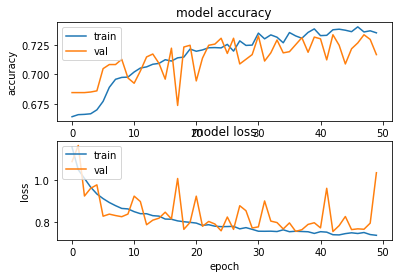

In [31]:
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'val'], loc='upper left')  
plt.show()

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)